In [ ]:
import pandas as pd

df = pd.read_csv('Training_comment_classifier.csv')

In [ ]:
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
stemmer = PorterStemmer()
stop_words = set(stopwords.words('indonesian'))

def preprocess_text(text):
    if not isinstance(text, str):
        return ''

    text = re.sub(r'[^\w\s]', '', text)
    words = word_tokenize(text.lower())
    words = [stemmer.stem(word) for word in words if word not in stop_words and word.isalpha()]
    return ' '.join(words)

df['processed_text'] = df['TweetText'].apply(preprocess_text)
print(df[['TweetText', 'processed_text']].head())

                                           TweetText  \
0                          @tekarok007 Penjilat!!! 🤣   
1  @Aryprasetyo85 ...kalau yang "empunya" kewenan...   
2  @NarasiNewsroom kaya si harun masiku ajah susa...   
3  @yaniarsim @kemkominfo @Gerindra Kita catet du...   
4                                                NaN   

                                      processed_text  
0                                           penjilat  
1  empunya kewenangan aja model harap indonesia m...  
2  narasinewsroom kaya si harun masiku ajah susah...  
3  yaniarsim kemkominfo gerindra catet diakui pri...  
4                                                     


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df['processed_text'], df['ContentAnalysis'], test_size=0.3, random_state=42)

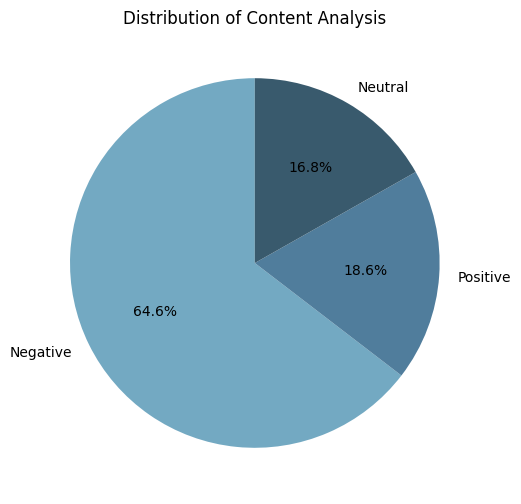

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
tosca_palette = ['#73A9C2', '#507D9C', '#395A6D']
y_train.value_counts().plot.pie(autopct='%1.1f%%', startangle=90, colors=tosca_palette)
plt.title('Distribution of Content Analysis')
plt.ylabel('')
plt.show()

In [ ]:
df = df.dropna(subset=['TweetText', 'ContentAnalysis'])

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=1000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score

svm = SVC(kernel = 'linear')
svm.fit(X_train_tfidf, y_train)

y_pred = svm.predict(X_test_tfidf)

print("Accuracy", accuracy_score(y_test,y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy 0.7631578947368421
Classification Report:
               precision    recall  f1-score   support

    Negative       0.97      0.89      0.93       367
     Neutral       0.00      0.00      0.00        86
    Positive       0.47      0.93      0.63       117

    accuracy                           0.76       570
   macro avg       0.48      0.61      0.52       570
weighted avg       0.72      0.76      0.73       570



In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf']
}

# Specify the number of folds (k)
k = 10  # You can change this to any number you prefer

grid_search = GridSearchCV(SVC(), param_grid, cv=k)  # Set cv to k
grid_search.fit(X_train_tfidf, y_train)

print("Best parameters found:")
print(grid_search.best_params_)
print("Best score:")
print(grid_search.best_score_)


Best parameters found:
{'C': 10, 'kernel': 'rbf'}
Best score:
0.7776657552973343


Confusion Matrix:
[[326   3  38]
 [  3   0  83]
 [  8   0 109]]


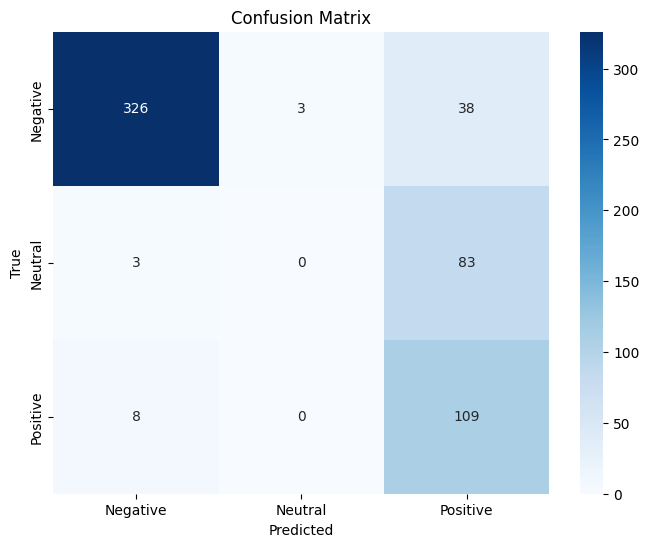

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)

# Print the confusion matrix
print("Confusion Matrix:")
print(cm)

# Create a heatmap for better visualization
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Neutral', 'Positive'],
            yticklabels=['Negative', 'Neutral', 'Positive'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [ ]:
results_df = pd.DataFrame({
    'Comment': df['TweetText'].values[:len(y_pred)],
    'True Label': y_test,
    'Predicted Label': y_pred
})
print(results_df.to_string(index=False))

                                                                                                                                                                                                                                                                                                    Comment True Label Predicted Label
                                                                                                                                                                                                                                                                                  @tekarok007 Penjilat!!! 🤣   Positive        Negative
                                                                                                      @Aryprasetyo85 ...kalau yang "empunya" kewenangan aja masih model begini2 terus JANGAN HARAP INDONESIA BISA MAJU. PAHAM !!!. ....Selamanya Indonesia akan terus dijadikan bancakan PARA BAJINGAN. !!!   Negative        Negative
                   

Unique labels in y_train: ['Negative' 'Neutral' 'Positive']


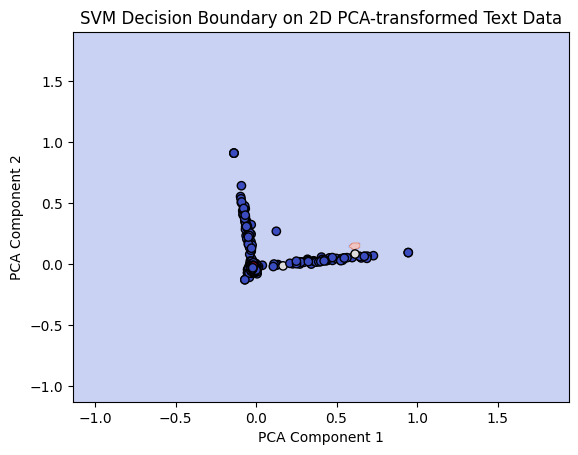

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import numpy as np

unique_labels = np.unique(y_train)
print("Unique labels in y_train:", unique_labels)

label_mapping = {label: idx for idx, label in enumerate(unique_labels)}

vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train).toarray()

pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_tfidf)

svm_model = SVC(kernel='rbf', C = 10)
svm_model.fit(X_train_pca, y_train)

# Step 4: Create a mesh grid for visualization
x_min, x_max = X_train_pca[:, 0].min() - 1, X_train_pca[:, 0].max() + 1
y_min, y_max = X_train_pca[:, 1].min() - 1, X_train_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                     np.arange(y_min, y_max, 0.01))

# Step 5: Predict decision boundary for mesh grid
Z = svm_model.predict(np.c_[xx.ravel(), yy.ravel()])  # Predict using the SVM model
Z_numeric = np.vectorize(label_mapping.get)(Z)  # Convert labels to integers
Z_numeric = Z_numeric.astype(float)  # Convert to float if needed
Z_numeric = Z_numeric.reshape(xx.shape)

# Step 6: Plot the decision boundary
plt.contourf(xx, yy, Z_numeric, alpha=0.3, cmap='coolwarm')  # Use the numeric Z for contour

# Map y_train to numeric labels for scatter
y_train_numeric = np.vectorize(label_mapping.get)(y_train)
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train_numeric, edgecolor='k', cmap='coolwarm')
plt.title("SVM Decision Boundary on 2D PCA-transformed Text Data")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()


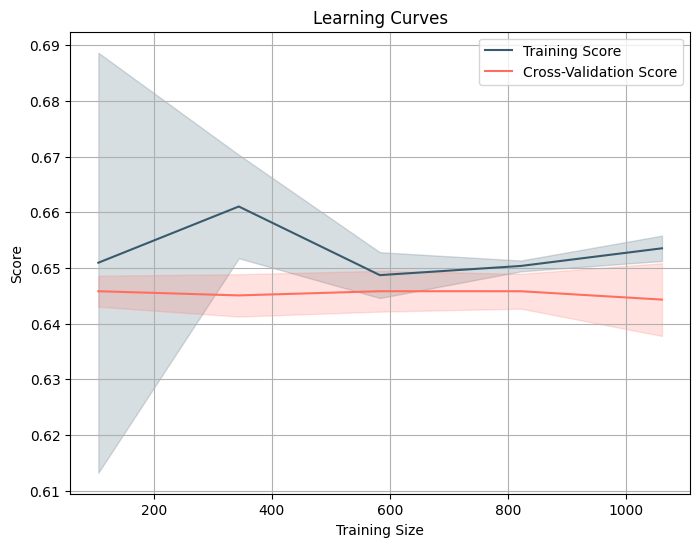

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer

tosca_palette = ['#395A6D', '#FF6F61']

vectorizer = TfidfVectorizer(max_features=1000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

classifier = MultinomialNB()
classifier.fit(X_train_tfidf, y_train)

train_sizes, train_scores, test_scores = learning_curve(classifier, X_train_tfidf, y_train, cv=5)

train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_mean, label='Training Score', color=tosca_palette[0])
plt.plot(train_sizes, test_mean, label='Cross-Validation Score', color=tosca_palette[1])

plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color=tosca_palette[0], alpha=0.2)
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color=tosca_palette[1], alpha=0.2)

plt.title('Learning Curves')
plt.xlabel('Training Size')
plt.ylabel('Score')
plt.legend()
plt.grid()
plt.show()


New Classification

In [ ]:
unlabeled_df = pd.read_csv('Tugas_Yosua.csv')

unlabeled_df['processed_text'] = unlabeled_df['TweetText'].apply(preprocess_text)

X_unlabeled_tfidf = vectorizer.transform(unlabeled_df['processed_text'])

new_predictions = svm.predict(X_unlabeled_tfidf)

unlabeled_df['ContentAnalysis'] = new_predictions

print(unlabeled_df[['TweetText', 'ContentAnalysis']])

                                              TweetText ContentAnalysis
0     Hari ini, Rabu 28 Agustus 2024 pasangan "RIDO"...        Negative
1     @PKSejahtera Yang menyesal pilih PKS 😢 mana li...        Negative
2     @PKSejahtera dulu bener-bener secara komprehen...        Negative
3     @PKSejahtera Semoga dimudahkan jalannya untuk ...        Negative
4     @PKSejahtera yang terbaik untuk jakarta \ninsy...        Negative
...                                                 ...             ...
1056  @SisikRubinatt @anonjawa apanya yg harus di pu...        Negative
1057  @anonjawa Ironisnya mereka itu dulu kita yg co...        Negative
1058  @anonjawa Emgnya sejak kapan parpol membawa as...        Negative
1059  @anonjawa Makanya dia sombong sudah didukung 1...        Negative
1060                                @anonjawa 𝙉𝙖𝙝𝙝𝙝....        Positive

[1061 rows x 2 columns]


In [ ]:
from google.colab import files

unlabeled_df.to_csv('Result_Yosua.csv', index=False)
files.download('Result_Yosua.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

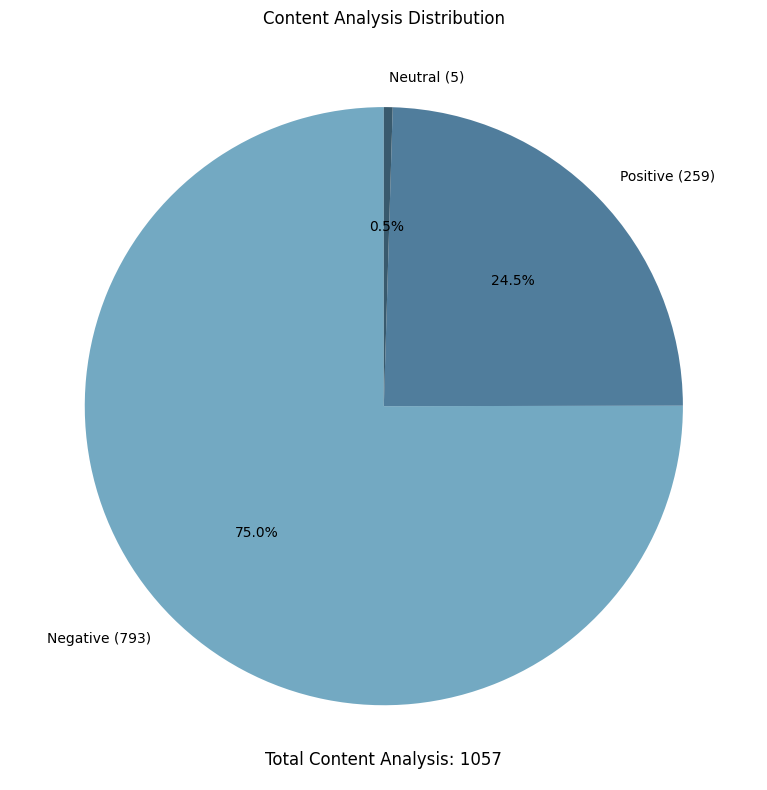

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

df_yosua = pd.read_csv('Result_Yosua.csv')

content_counts = df_yosua['ContentAnalysis'].value_counts()

tosca_palette = ['#73A9C2', '#507D9C', '#395A6D']

labels = [f'{label} ({count})' for label, count in zip(content_counts.index, content_counts.values)]

plt.figure(figsize=(8, 8))
plt.pie(content_counts, labels=labels, autopct='%1.1f%%', startangle=90, colors=tosca_palette)
plt.title('Content Analysis Distribution')

total_count = content_counts.sum()

plt.text(0, -1.2, f'Total Content Analysis: {total_count}', ha='center', fontsize=12, color='black')

plt.tight_layout()
plt.show()


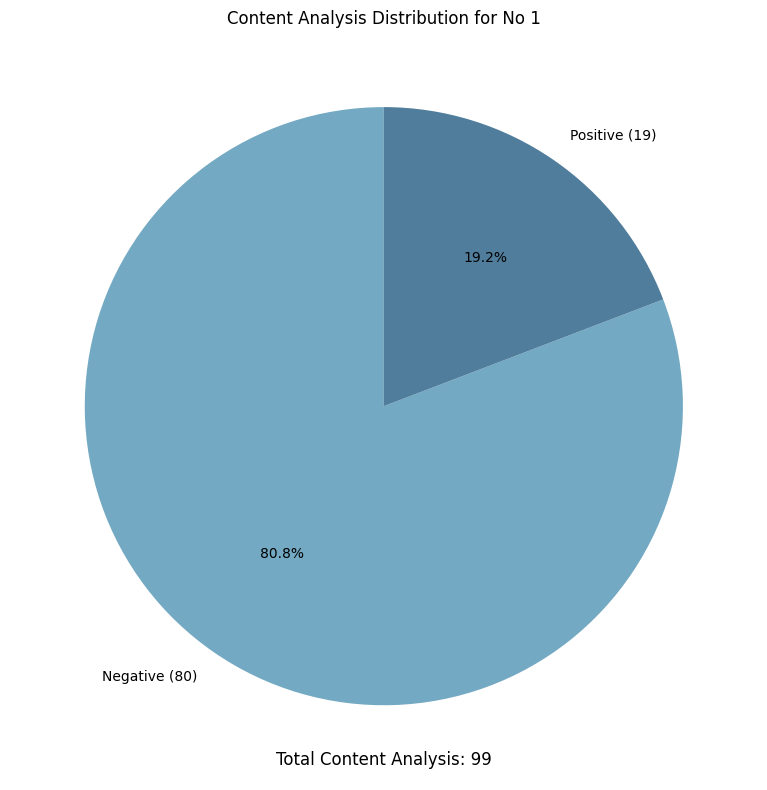

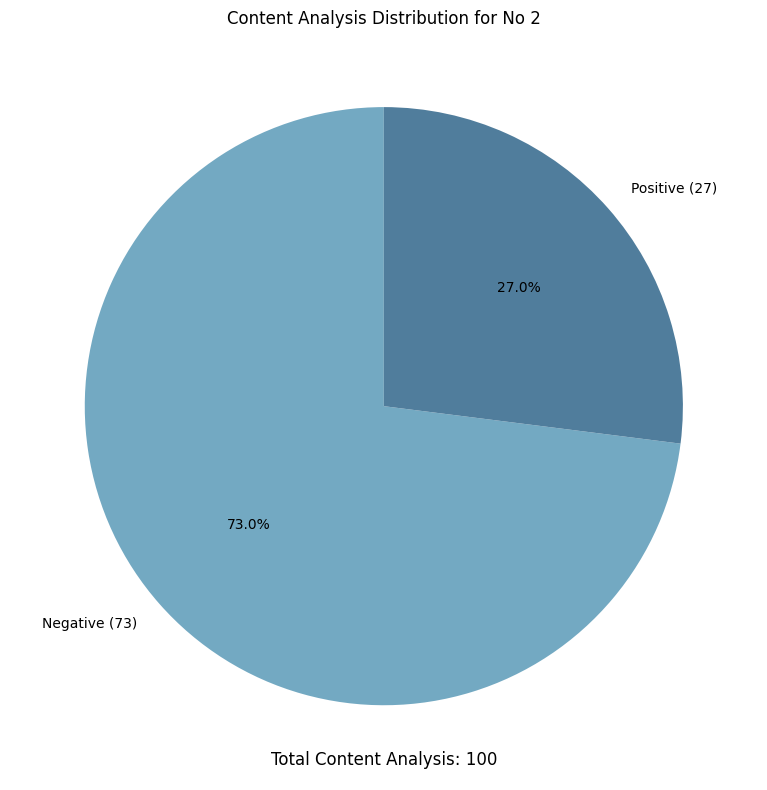

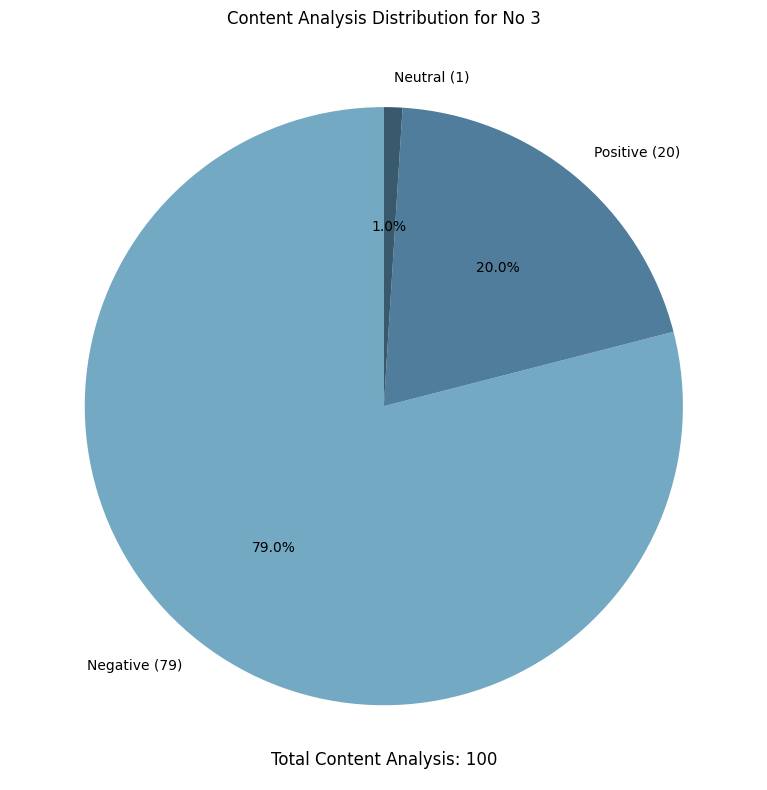

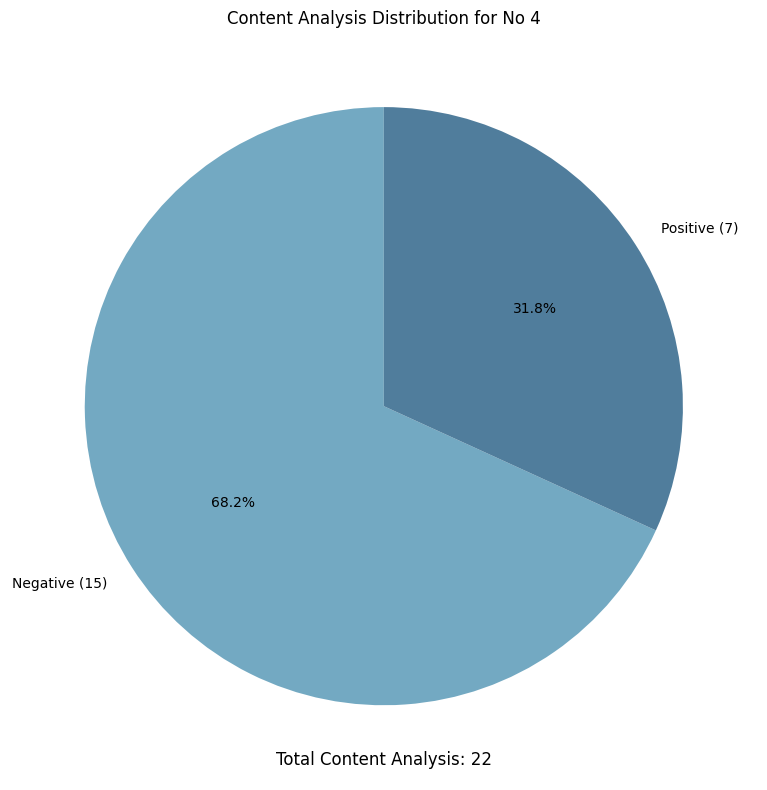

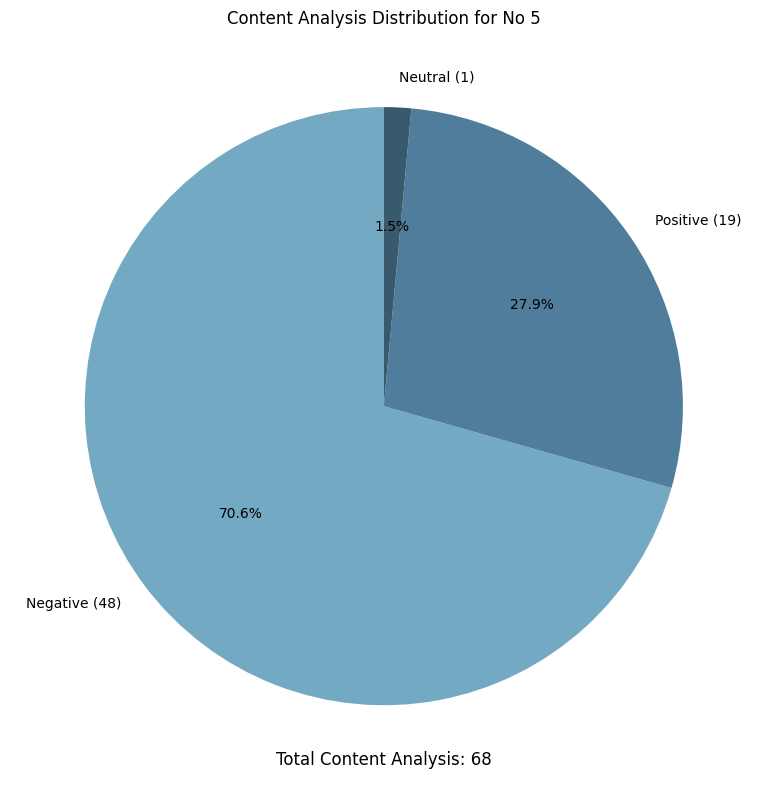

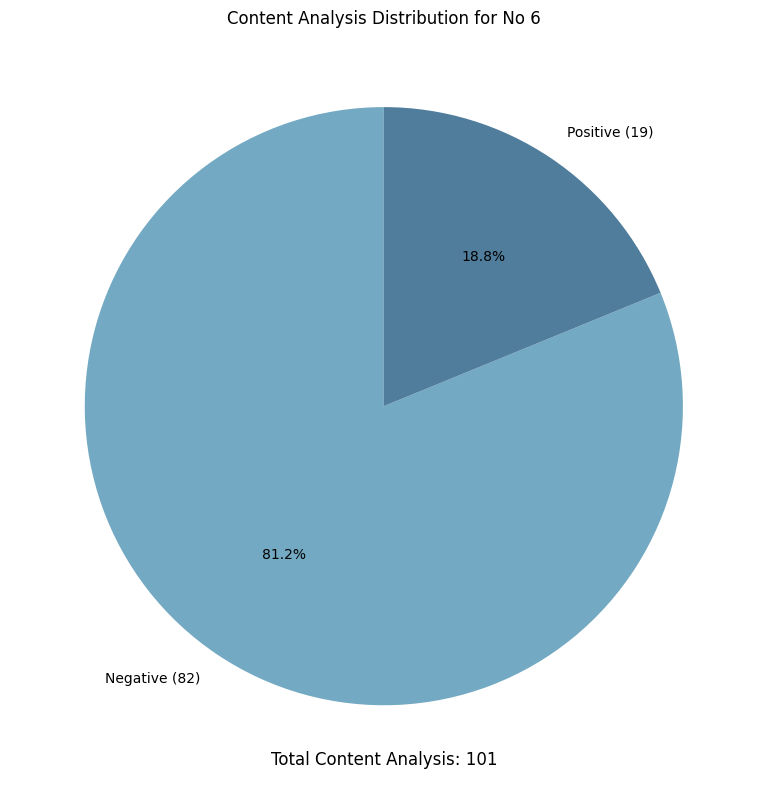

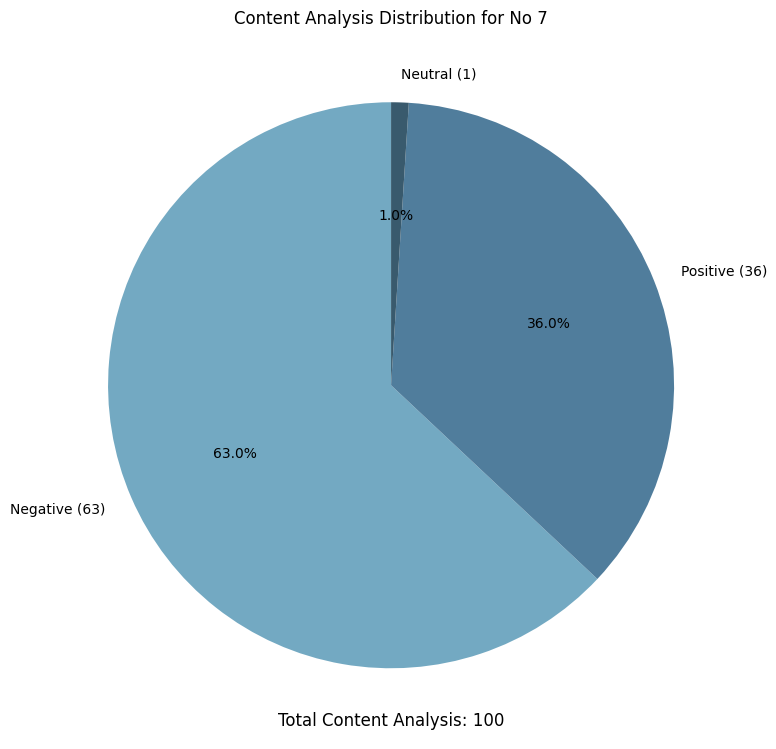

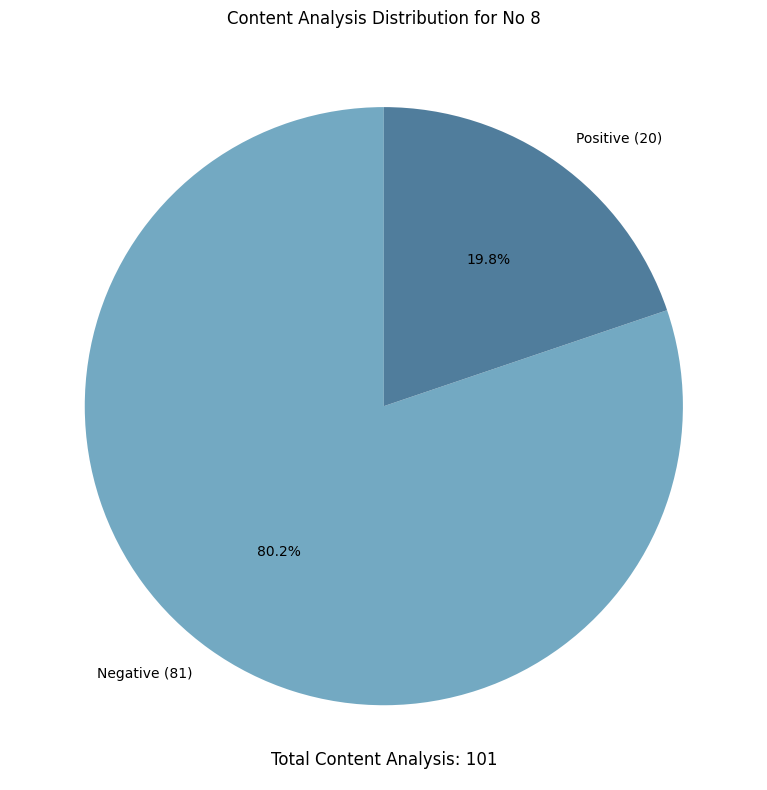

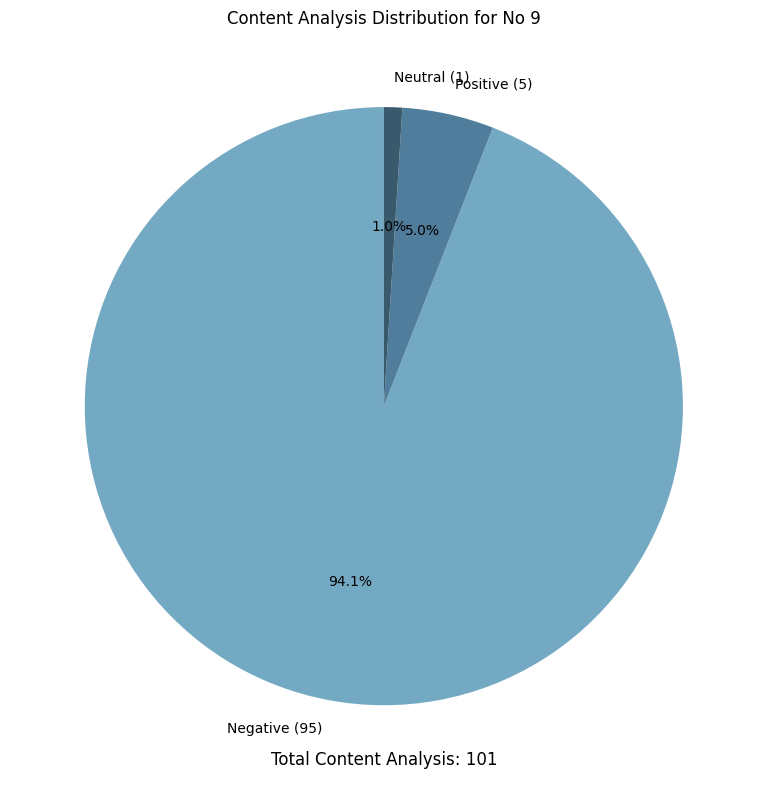

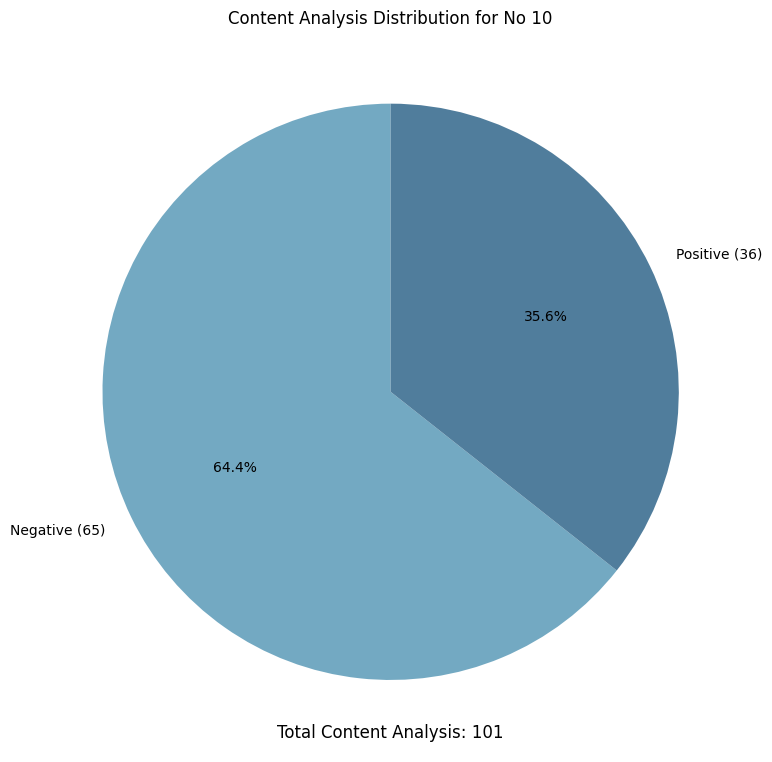

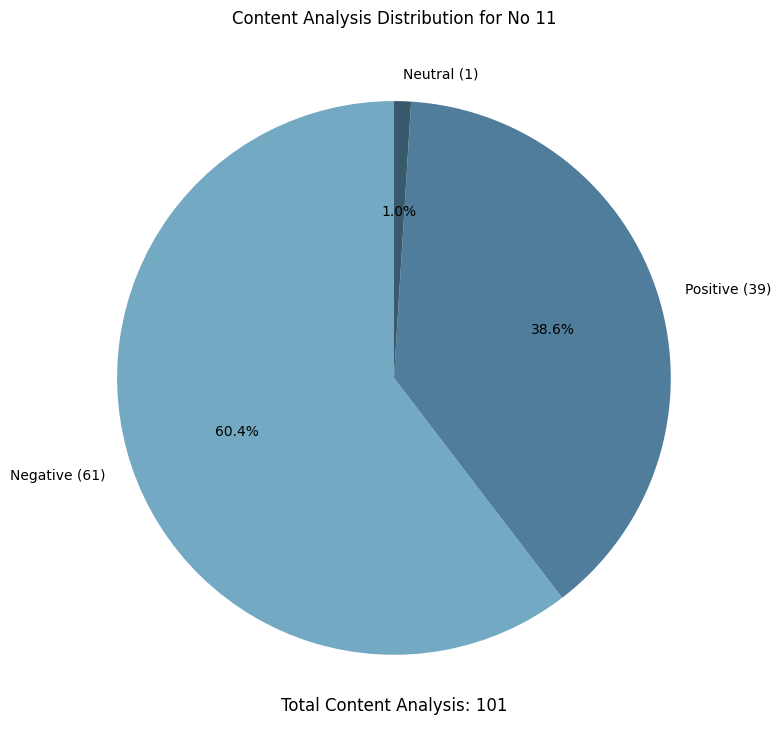

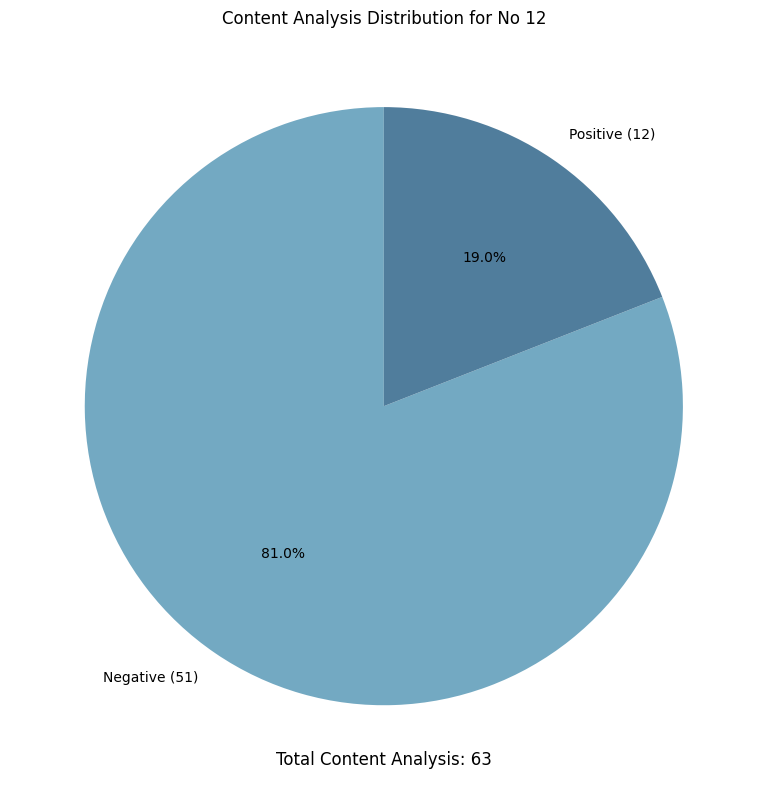

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load your CSV file
df_yosua = pd.read_csv('Result_Yosua.csv')

# Define the Tosca palette
tosca_palette = ['#73A9C2', '#507D9C', '#395A6D']

# Get the unique values of 'No'
unique_nos = df_yosua['No'].unique()

# Loop through each unique 'No' and create a pie chart
for no in unique_nos:
    # Filter the data for the current 'No'
    data_by_no = df_yosua[df_yosua['No'] == no]

    # Get the counts of each 'ContentAnalysis' for this 'No'
    content_counts = data_by_no['ContentAnalysis'].value_counts()

    # Create labels with counts
    labels = [f'{label} ({count})' for label, count in zip(content_counts.index, content_counts.values)]

    # Create the pie chart
    plt.figure(figsize=(8, 8))
    plt.pie(content_counts, labels=labels, autopct='%1.1f%%', startangle=90, colors=tosca_palette)

    # Set the title for each 'No'
    plt.title(f'Content Analysis Distribution for No {no}')

    # Add text below the chart with the total count of ContentAnalysis for the current 'No'
    total_count = content_counts.sum()
    plt.text(0, -1.2, f'Total Content Analysis: {total_count}', ha='center', fontsize=12, color='black')

    # Display the chart
    plt.tight_layout()
    plt.show()
